In [3]:
import pandas as pd
from scipy.interpolate import interp1d,CubicSpline
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
import math
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = 15, 10
from scipy.optimize import minimize
import panel as pn
pn.extension('tabulator')
from panel.interact import interact

import hvplot.pandas
from panel.reactive import ReactiveHTML
import param
class MaterialBase(ReactiveHTML):
    
    __javascript__ = ['https://unpkg.com/material-components-web@latest/dist/material-components-web.min.js']
    
    __css__ = ['https://unpkg.com/material-components-web@latest/dist/material-components-web.min.css']

pn.extension()

In [4]:
class MaterialTextField(MaterialBase):
    
    value = param.String(default='')
    
    _template = """
    <label id="text-field" class="mdc-text-field mdc-text-field--filled">
      <span class="mdc-text-field__ripple"></span>
      <span class="mdc-floating-label">Label</span>
      <input id="text-input" type="text" class="mdc-text-field__input" aria-labelledby="my-label" value="${value}"></input>
      <span class="mdc-line-ripple"></span>
    </label>
    """
    
    _dom_events = {'text-input': ['change']}
    
    _scripts = {
        'render': "mdc.textField.MDCTextField.attachTo(text_field);"
    }
    
class MaterialSlider(MaterialBase):
    
    end = param.Number(default=100)
    
    start = param.Number(default=0)
    
    value = param.Number(default=50)
    
    _template = """
    <div id="mdc-slider" class="mdc-slider" style="width: ${model.width}px">
      <input id="slider-input" class="mdc-slider__input" min="${start}" max="${end}" value="${value}">
      </input>
      <div class="mdc-slider__track">
        <div class="mdc-slider__track--inactive"></div>
        <div class="mdc-slider__track--active">
          <div class="mdc-slider__track--active_fill"></div>
        </div>
      </div>
      <div class="mdc-slider__thumb">
        <div class="mdc-slider__thumb-knob"></div>
      </div>
    </div>
    """
    
    _scripts = {        
        'render': """
            slider_input.setAttribute('value', data.value)
            state.slider = mdc.slider.MDCSlider.attachTo(mdc_slider)
        """,
        'value': """
            state.slider.setValue(data.value)
        """
    }

In [5]:
y = pn.widgets.IntInput(name='Année', value=12, step=1, start=0, end=20)
m=pn.widgets.IntInput(name='Mois', value=0, step=1, start=0, end=12)
d=K=pn.widgets.IntInput(name='Days', value=0, step=1, start=0, end=30)

In [6]:
data=pd.read_excel('C:/Users/hp/Downloads/data.xlsx')
data.columns
data['Date']=pd.to_datetime(data['Date '])
d1= pd.to_datetime('2022/11/27')
type(data['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
def days_between(d1, d2):
    k=[]
    for i in d1:
        k.append(abs((i - d2).days)/365)
    return k

In [8]:
data['period']=days_between(data['Date'],d1)

In [9]:
period =data['period']
taux=data['Taux moyen']

In [10]:
cs =interp1d(data['period'],data['Taux moyen'] )
CUBIQUE=interp1d(data['period'],data['Taux moyen'],kind='cubic' )
curve_points = np.linspace(min(data['period']), max(data['period']), 1000)
cs(20)
CUBIQUE(20)

array(0.03446966)

In [11]:
def NSS(m,vi):
    k=0
    k=vi[0]+vi[1]*((1-np.exp(-m/vi[4]))/(m/vi[4]))
    + vi[2]*((1-np.exp(-m/vi[4]))/(m/vi[4])-np.exp(-m/vi[4]))
    
    return k

In [12]:
def nso1(taux,period,A):
    beta0=np.max(taux)
    beta1=np.max(taux)-np.min(taux)
    beta2=2*np.mean(taux)-np.max(taux)-np.min(taux)
    beta3=17*np.mean(taux)-np.max(taux)-np.min(taux)
    tau1=5
    tau2=100000
    vi=[beta0,beta1,beta2,beta3,tau1,tau2]
    def list_taux1(m,vi):
        taux_=[]
        for i in m:
            t= NSS(i,vi)
            taux_.append(t)
        return taux_
#on trouve l'erreur
    def obj1(facteur):
        e=(list_taux1(period,facteur)-taux)**2
        scr= np.sum(e)
        return scr
    #on cherche les coefficiants optimiser
    resultat= minimize(obj1,vi)
    obj_fct= resultat.fun
    vo=resultat.x
    return NSS(A,vo)

In [13]:
def nso(taux,period):
    beta0=np.max(taux)
    beta1=np.max(taux)-np.min(taux)
    beta2=2*np.mean(taux)-np.max(taux)-np.min(taux)
    beta3=17*np.mean(taux)-np.max(taux)-np.min(taux)
    tau1=5
    tau2=100000
    vi=[beta0,beta1,beta2,beta3,tau1,tau2]
    def list_taux1(m,vi):
        taux_=[]
        for i in m:
            t= NSS(i,vi)
            taux_.append(t)
        return taux_
#on trouve l'erreur
    def obj1(facteur):
        e=(list_taux1(period,facteur)-taux)**2
        scr= np.sum(e)
        return scr
    #on cherche les coefficiants optimiser
    resultat= minimize(obj1,vi)
    obj_fct= resultat.fun
    vo=resultat.x
    return list_taux1(period,vo)

In [14]:
def NSSA(m,vi):
    k=0
    k=vi[0]+vi[1]*((1-np.exp(-m/vi[4]))/(m/vi[4]))
    + vi[2]*((1-np.exp(-m/vi[4]))/(m/vi[4])-np.exp(-m/vi[4]))
    + vi[3]*((1-np.exp(-m/vi[5]))/(m/vi[5])-np.exp(-m/vi[5]))
    return k

In [15]:
def nsao1(taux,period,A):
    beta0=np.max(taux)
    beta1=np.max(taux)-np.min(taux)
    beta2=2*np.mean(taux)-np.max(taux)-np.min(taux)
    beta3=17*np.mean(taux)-np.max(taux)-np.min(taux)
    tau1=5
    tau2=100000
    vi=[beta0,beta1,beta2,beta3,tau1,tau2]
    def list_taux(m,vi):
        taux_=[]
        for i in m:
            t= NSSA(i,vi)
            taux_.append(t)
        return taux_
#on trouve l'erreur
    def obj(facteur):
        e=(list_taux(period,facteur)-taux)**2
        scr= np.sum(e)
        return scr
    #on cherche les coefficiants optimiser
    resultat= minimize(obj,vi)
    obj_fct= resultat.fun
    vo=resultat.x
    return NSSA(A,vo)

In [16]:
def nsao(taux,period):
    beta0=np.max(taux)
    beta1=np.max(taux)-np.min(taux)
    beta2=2*np.mean(taux)-np.max(taux)-np.min(taux)
    beta3=17*np.mean(taux)-np.max(taux)-np.min(taux)
    tau1=5
    tau2=100000
    vi=[beta0,beta1,beta2,beta3,tau1,tau2]
    def list_taux(m,vi):
        taux_=[]
        for i in m:
            t= NSSA(i,vi)
            taux_.append(t)
        return taux_
#on trouve l'erreur
    def obj(facteur):
        e=(list_taux(period,facteur)-taux)**2
        scr= np.sum(e)
        return scr
    #on cherche les coefficiants optimiser
    resultat= minimize(obj,vi)
    obj_fct= resultat.fun
    vo=resultat.x
    return list_taux(period,vo)

In [17]:
    def vasicek(r,NO,N, seed=777):   

        np.random.seed(seed)
        dt = NO[2]/float(N)    
        rates = [r]
        for i in range(N-1):
            dr = NO[0]*( NO[1]-rates[-1])*dt + NO[3]*np.random.normal()
            rates.append(rates[-1] + dr)
        return  rates

In [18]:
def vasicek_o(taux,period):
    K=3
    theta=3
    sigma=taux.std()
    T=period.mean()
    N=len(period)
    NO=[K,theta,T,sigma]
    T/N
    def vasicek(r,NO,N, seed=777):   

        np.random.seed(seed)
        dt = NO[2]/float(N)    
        rates = [r]
        for i in range(N-1):
            dr = NO[0]*( NO[1]-rates[-1])*dt + NO[3]*np.random.normal()
            rates.append(rates[-1] + dr)
        return  rates
    def obj4(facteur):
        e=(vasicek(taux[0], facteur,N, seed=444)-taux)**2
        scr= np.sum(e)
        return scr
    resultat= minimize(obj4,NO)
    obj_fct= resultat.fun
    vo1=resultat.x
    return vasicek(taux[0], vo1,N, seed=444)

In [19]:
def cir(r0, NO,N, seed=777):

        np.random.seed(seed)
        dt = NO[2]/float(N) 
        rates=[r0]
        for i in range(N-1):
            dr = NO[0]*(NO[1]-rates[-1])*dt +NO[3]*math.sqrt(abs(rates[-1]))*np.random.normal()
            rates.append(rates[-1] + dr)
        return rates

In [20]:
def cir_o1(taux,period):
    K=3
    theta=3
    sigma=taux.std()
    T=period.mean()
    N=len(period)
    NO=[K,theta,T,sigma]
    T/N
    def cir(r0, NO,N, seed=777):

        np.random.seed(seed)
        dt = NO[2]/float(N) 
        rates=[r0]
        for i in range(N-1):
            dr = NO[0]*(NO[1]-rates[-1])*dt +NO[3]*math.sqrt(abs(rates[-1]))*np.random.normal()
            rates.append(rates[-1] + dr)
        return rates
    def obj4(facteur):
        e=(cir(taux[0], facteur,N, seed=444)-taux)**2
        scr= np.sum(e)
        return scr
    resultat= minimize(obj4,NO)
    obj_fct= resultat.fun
    vo1=resultat.x
    return cir(taux[0], vo1,N, seed=444)

In [21]:
@param.depends("m"," d", "y", watch=True)

def frames (m, d, y, period,taux):

    yo=y+d/365+m/12
    

    model_pricing = {'Price': [cs(yo),CUBIQUE(yo),nso1(taux,period,yo),nsao1(taux,period,yo)]}
    model_pricing_frame = pd.DataFrame(model_pricing, columns=[ 'Price'], index = ['interpolation lineaire','interpolation cubique','Nelson-Siegel-Svensson','Nelson-Siegel-Svensson-Ajusté'])                                        
    return model_pricing_frame
model_pricing_frames= pn.bind(frames, m=m, d=d, y=y, period=period, taux=taux)

In [22]:
cs =interp1d(data['period'],data['Taux moyen'] )
CUBIQUE=interp1d(data['period'],data['Taux moyen'],kind='cubic' )
curve_points = np.linspace(min(data['period']), max(data['period']), 1000)
cs

In [32]:

def dessin(data):
    cs =interp1d(data['period'],data['Taux moyen'] )
    CUBIQUE=interp1d(data['period'],data['Taux moyen'],kind='cubic' )
    curve_points = np.linspace(min(data['period']), max(data['period']), 1000)
    plt.figure()
    plt.title('Courbe des taux interpolation\nDate: 27/11/2022', fontsize = 15)
    plt.xlabel('maturité')
    plt.ylabel('taux (%)')
    plt.plot(data['period'], data['Taux moyen'], 'o', label = 'yield data points')
    plt.plot(curve_points, cs(curve_points), label="interpolation lineaire")
    plt.plot(data['period'], nsao(data['Taux moyen'],data['period']), label="Nielsons-siegle-ajusté")
    plt.plot(data['period'],vasicek_o(data['Taux moyen'],data['period']),label="vasicek")
    plt.plot(data['period'],cir_o1(data['Taux moyen'],data['period']),label="cir")
    plt.plot(data['period'], nso(data['Taux moyen'],data['period']), label="Nielsons-siegle")
    plt.plot(curve_points, CUBIQUE(curve_points), label="interpolation cubique")
    plt.grid(linestyle = '--', linewidth = 1)
    plt.legend()
    plt.show()


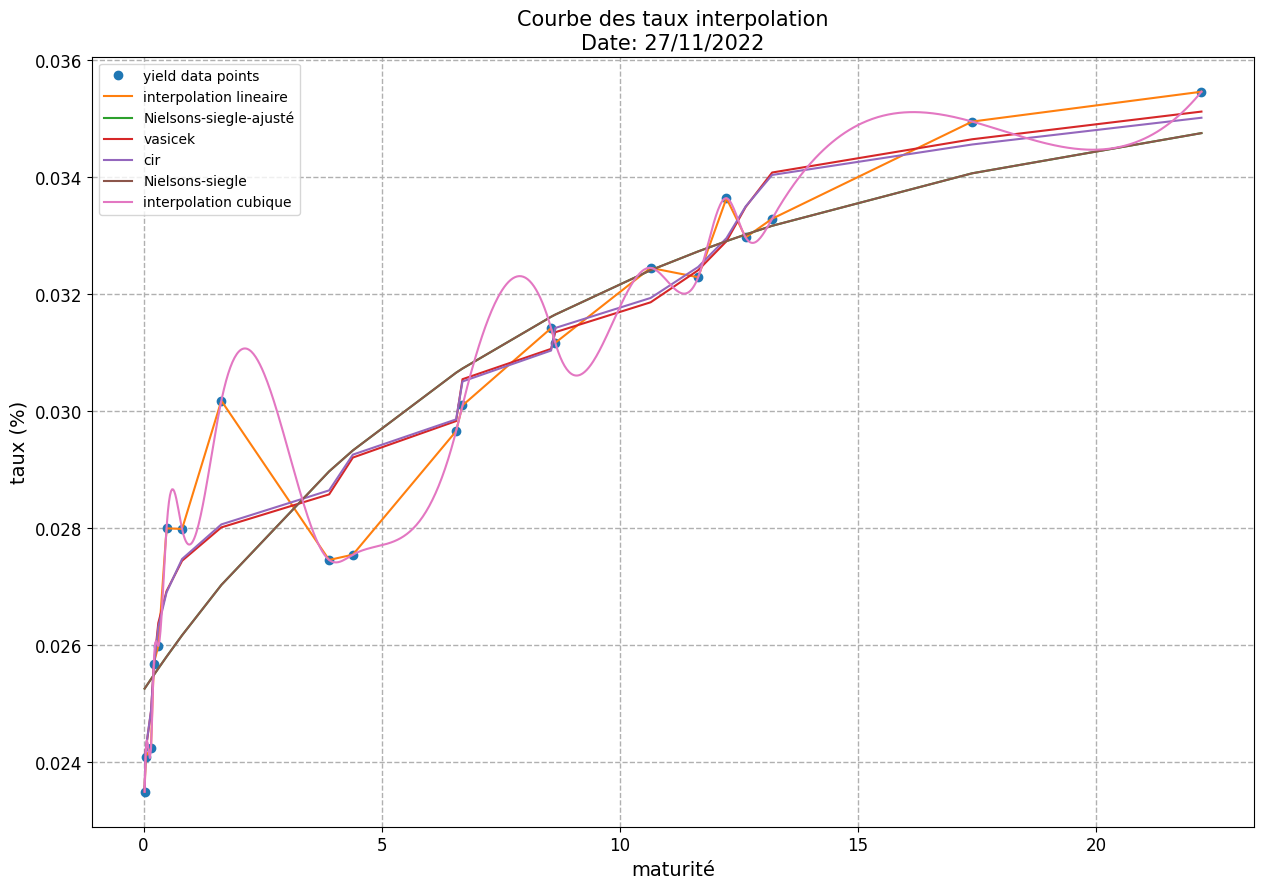

In [33]:
#Layout using Template
template = pn.template.FastListTemplate(
    title='Courbe des taux par les différentes modéles', 
    sidebar=[pn.pane.Markdown("Choisissez votre paramètre"), y, m, d],
    main=[
        pn.pane.Markdown("Résultat des modéles"),
        pn.Row(pn.Column(model_pricing_frames)),pn.Row(
                 dessin(data))
 
])
# template.show()
template.servable();